# Neural Turing Machine with Keras
Definitions:
$h$ controller RNN state. $M$ memory (a matrix). $r$ and $w$ read and write vectors, output of a softmax, thus a probability distribution, they are used to do weighted averaging (it seems that differentiable attention is the new name for that) over the rows of $M$. The rows of $M$ are the different "memory locations".  

Internal algorithm:
1) Using $h_{t-1}$, update the reading vector $r_t = f_r(r_{t-1}, h_{t-1})$  
2) Read from memory $m_t = read(r_t, M_{t-1})$  
3) Using the input and the read vector, update the RNN controller state $RNN$: $h_t = RNN(x_t, m_t, h_{t-1})$  
4) Using $h_t$, update the writing vector $w_t = f_w(w_{tm1}, h_t)$  
5) Write to memory $M_t = write(M_{t-1}, h_t, w_t)$.  
For details see Graves et. al.. Next we are going to run the Copy experiment in PyTorch  

# Copy Problem


In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import logging
import time
import numpy as np
np.random.seed(1234)

import torch
torch.backends.cudnn.benchmark = True
import torch.nn.functional as F
from torch import Tensor
from torch.autograd import Variable
from torch.nn import Parameter, Module, Linear
from torch.nn.utils import clip_grad_norm

from torch.optim import Adam

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler

import matplotlib.pyplot as plt

# Steal the progbar from Keras
from seya_pytorch.utils import generic_utils

from seya_pytorch.layers.ntm import NTM

from IPython import display

In [2]:
class NTMModel(Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, input_dim, hidden_size, m_length, n_slots, shift_range = 3):

        super(NTMModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.m_length = m_length
        self.n_slots = n_slots
        self.shift_range = shift_range

        self.ntm = NTM(input_dim, hidden_size, m_length, n_slots)
        self.fc1 = Linear(hidden_size, input_dim)

        self.init_states()

    def init_states(self):
        # Initial memory and head for the NTM
        self.memory = Parameter(torch.ones(1, self.n_slots, self.m_length) * 1e-3)
        self.read_head = Parameter(Tensor(1, self.n_slots))
        self.write_head = Parameter(Tensor(1, self.n_slots))

        # Initial states for the LSTM controller of the NTM
        self.h = Parameter(torch.zeros(1, self.hidden_size))
        self.c = Parameter(torch.zeros(1, self.hidden_size))

        # Since the initial read and write heads are basically weights we'll initialise them like weights
        bound = np.sqrt(6.0 / (1 + self.n_slots))
        self.read_head.data.uniform_(bound, -bound)
        self.write_head.data.uniform_(bound, -bound)

    def get_init_states(self, batch_size):
        memory = self.memory.expand(batch_size, self.n_slots, self.m_length).contiguous()
        read_head = F.softmax(self.read_head.expand(batch_size, self.n_slots).contiguous())
        write_head = F.softmax(self.write_head.expand(batch_size, self.n_slots).contiguous())

        h = self.h.expand(batch_size, self.hidden_size).contiguous()
        c = self.c.expand(batch_size, self.hidden_size).contiguous()

        return [h, c], [read_head, write_head], memory

    def forward(self, inp, states, heads, memory):

        ntm_out = self.ntm(inp, states, heads, memory)
        out = F.sigmoid(self.fc1(ntm_out[0][0]))

        return out, ntm_out

In [3]:
# Steal this from EderSanta/Seya
def get_sample(batch_size=128, n_bits=8, max_size=20, min_size=1):
    # generate samples with random length
    inp = np.zeros((batch_size, 2*max_size-1, n_bits))
    out = np.zeros((batch_size, 2*max_size-1, n_bits))
    sw = np.zeros((batch_size, 2*max_size-1, 1))
    for i in range(batch_size):
        t = np.random.randint(low=min_size, high=max_size)
        x = np.random.uniform(size=(t, n_bits)) > .5
        for j,f in enumerate(x.sum(axis=-1)): # remove fake flags
            if f>=n_bits:
                x[j, :] = 0.
        del_flag = np.ones((1, n_bits))
        inp[i, :t+1] = np.concatenate([x, del_flag], axis=0)
        out[i, t:(2*t)] = x
        sw[i, t:(2*t)] = 1
    return inp, out, sw

In [4]:
# Steal this from EderSanta/Seya too
def show_pattern(inp, out, sw, file_name='pattern2.png'):
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(inp>.5)
    plt.subplot(132)
    plt.imshow(out>.5)
    plt.subplot(133)
    plt.imshow(sw[:, :1]>.5)
    plt.savefig(file_name)
    plt.close()

inp, out, sw = get_sample()
show_pattern(inp[0], out[0], sw[0])

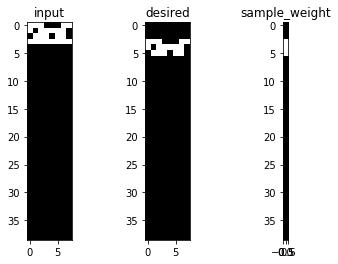

In [5]:
# Steal this from EderSanta/Seya
inp, out, sw = get_sample(1, 8, 20)

plt.subplot(131)
plt.title('input')
plt.imshow(inp[0], cmap='gray')
plt.subplot(132)
plt.title('desired')
plt.imshow(out[0], cmap='gray')
plt.subplot(133)
plt.title('sample_weight')
plt.imshow(sw[0], cmap='gray')

# sample_weight marks the points in time that will 
# be part of the cost function.

In [6]:
#(self, input_dim, hidden_size, m_length, n_slots, shift_range = 3)
model = NTMModel(8, 64, 20, 50)
model.cuda()
optimizer = Adam(model.parameters(), lr = 0.001)

 500/4000 [==>...........................] - ETA: 2125s - loss: 0.1658
accuracy  0.854931640625
1000/4000 [======>.......................] - ETA: 1761s - loss: 0.1594
accuracy  0.861376953125
1500/4000 [==========>...................] - ETA: 1552s - loss: 0.1448
accuracy  0.909619140625
2000/4000 [==============>...............] - ETA: 1305s - loss: 0.1196
accuracy  0.874951171875
2500/4000 [=================>............] - ETA: 1005s - loss: 0.1028
accuracy  0.74296875
3000/4000 [=====================>........] - ETA: 682s - loss: 0.0944
accuracy  0.756494140625
3500/4000 [=========================>....] - ETA: 345s - loss: 0.0868
accuracy  0.7716796875
4000/4000 [==============================] - 2795s - loss: 0.0784  

accuracy  0.77783203125


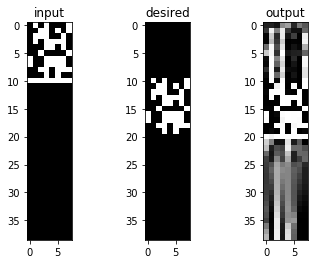

In [7]:
nb_epoch = 4000
batch_size = 128
progbar = generic_utils.Progbar(nb_epoch)
for e in range(nb_epoch):
    
    data, targets, weights = get_sample(n_bits=8, max_size=20, min_size=1, batch_size=batch_size)

    x = Variable(torch.from_numpy(np.transpose(data, (1, 0, 2))).float()).cuda()
    t = Variable(torch.from_numpy(np.transpose(targets, (1, 0, 2))).float()).cuda()
    w = Variable(torch.from_numpy(np.transpose(weights, (1, 0, 2))).float()).cuda()

    model.zero_grad()
    out = []
    states = model.get_init_states(batch_size)
    x = x.chunk(x.size()[0])
    for xi in x:
        o = model(xi.squeeze(), *states)
        states = o[1]
        out += [o[0]]
    out = torch.stack(out, dim = 0)
    loss = F.binary_cross_entropy(out * w.expand_as(out), t)
    loss.backward()
    clip_grad_norm(model.parameters(), 10)
    optimizer.step()

    progbar.add(1, values=[("loss", loss.data.cpu().numpy())])
    if int(e + 1) % 500 == 0:
        out_np = np.transpose(np.round(out.data.cpu().numpy()), (1, 0, 2))
        acc = (out_np == targets).sum() / (weights.sum() * 8)
        print('\naccuracy ', acc)

        plt.subplot(131)
        plt.title('input')
        plt.imshow(data[0], cmap='gray')
        plt.subplot(132)
        plt.title('desired')
        plt.imshow(targets[0], cmap='gray')
        plt.subplot(133)
        plt.title('output')
        plt.imshow(out.data.cpu().numpy()[:, 0], cmap='gray')

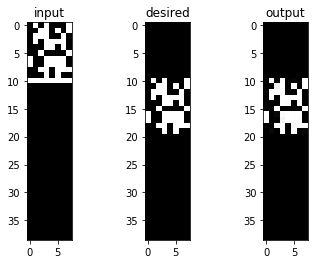

In [10]:
plt.subplot(131)
plt.title('input')
plt.imshow(data[0], cmap='gray')
plt.subplot(132)
plt.title('desired')
plt.imshow(targets[0], cmap='gray')
plt.subplot(133)
plt.title('output')
plt.imshow(out.data.cpu().numpy()[:, 0] * weights[0], cmap='gray')

In [11]:
torch.save(model.state_dict(), 'ntm_copy.nn')
# We can load using model.load_state_dict(torch.load('ntm_copy.nn'))